Note to graders: I generated a 1000 molecule subset of the data to use for the tSNE visualization and for hierarchical clustering. It was generated by choosing random molecules without replacement. The code to generate the subset indices is in my Q2 code.

Also, some of the cells have redundant code (ex: loading the same modules or same data in multiple cells). This is intentional. I did not run all the cells at once so sometimes I had to reload modules or data.

### Question 1
answer

### Question 2
Out of curiosity, I decided to try out both PCA and tSNE. I ran PCA on all of the molecules, and I ran tSNE on the 1000 molecule subset. For subsequent visualizations, I include results for both PCA and tSNE because I think it gives a more comprehensive picture than just using one of them.

In [24]:
from clusters import algs
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load ligands
ligs = algs.load_ligands("ligand_information.csv")

# Get dense representation of bits
lig_coords = np.array([l.bit_string for l in ligs])

# Pre-process data
sc = StandardScaler()
lc_pp = sc.fit_transform(lig_coords)

# Do PCA
pca = PCA(n_components=2)
lc_pca = pca.fit_transform(lc_pp)

# Save pca values for future reference
np.save("part2_results_data/q2-pca_vals.npy", np.asarray(lc_pca))

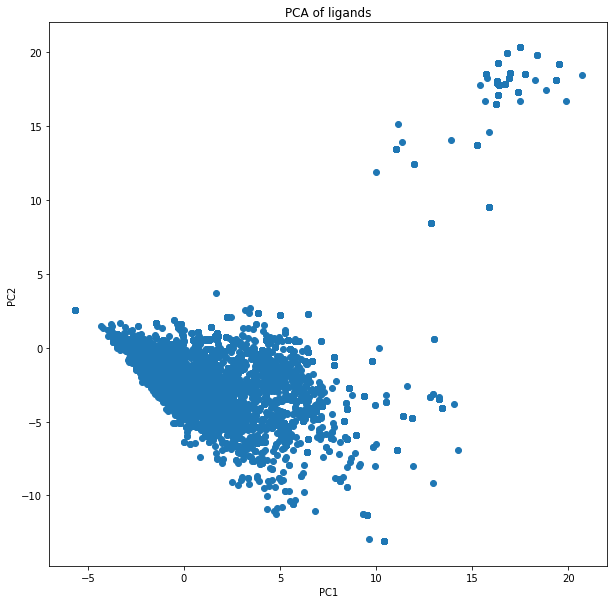

In [25]:
import matplotlib.pyplot as plt

# Plot PCA results
plt.rcParams["figure.figsize"] = (10,10)
plt.scatter(lc_pca[:,0], lc_pca[:,1])
plt.title("PCA of ligands")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.savefig("part2_plots/q2-pca.png")

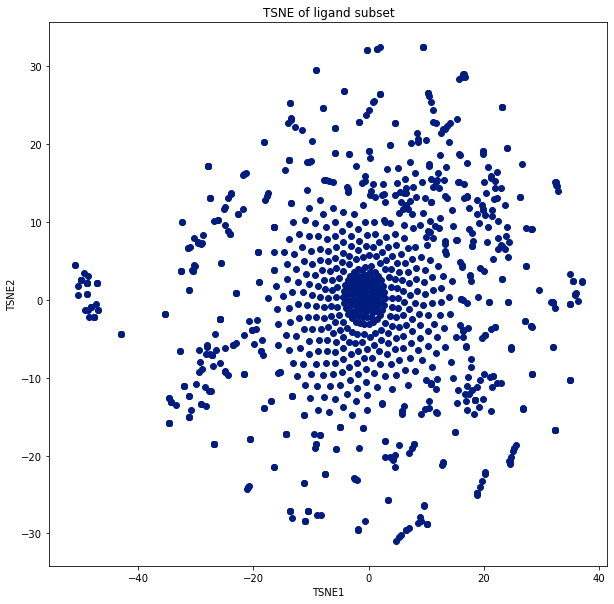

In [94]:
from clusters import algs
import numpy as np
import sklearn
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load ligands
ligs = algs.load_ligands("ligand_information.csv")

# Get dense representation of bits
lig_coords = np.array([l.bit_string for l in ligs])

# Get subset
subset_idx = np.random.choice(len(lig_coords), size=1000, replace=False)
sub_idx = np.sort(subset_idx)
lig_subset = lig_coords[sub_idx,:]

# Save subset indices for future reference
np.save("part2_results_data/sub_idx.npy", sub_idx)

# Do TSNE
tsne = TSNE()
lc_tsne = tsne.fit_transform(lig_subset)

# Save tsne values for future reference
np.save("part2_results_data/q2-tsne_vals.npy", np.asarray(lc_tsne))

# Plot TSNE results
plt.rcParams["figure.figsize"] = (10,10)
plt.scatter(lc_tsne[:,0], lc_tsne[:,1])
plt.title("TSNE of ligand subset")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.savefig("part2_plots/q2-tsne.png")

Interestingly, the plots look pretty different although I guess that's not super surprising since they are different dimensionality reduction algorithms. Both of them seem to have one really big cluster and one small cluster.

### Question 3

In [11]:
from clusters import algs
import numpy as np

# Load ligands
ligs = algs.load_ligands("ligand_information.csv")
lig_coords = np.array([l.bit_string for l in ligs])

# Evaluate number of clusters
k_scores = {}
for k in range(2,11):
    pck = algs.PartitionClustering(k)
    ck = pck.cluster(lig_coords)
    s = algs.compute_silhouette_score(ck, lig_coords)
    k_scores[k] = s
print(k_scores)

# Save results
np.save("part2_results_data/q3-kscores.npy", np.asarray(list(k_scores.items())))

{2: 0.11931603541037976, 3: 0.35235852718321137, 4: 0.3518311234088012, 5: 0.36090025292274874, 6: 0.32974020031255097, 7: 0.38072777841271555, 8: 0.3605417802619046, 9: 0.3705720428627395, 10: 0.38529953960441404}


In [11]:
# k=10 had the highest silhouette score so I will forge ahead with that

# Load ligands
ligs = algs.load_ligands("ligand_information.csv")
lig_coords = np.array([l.bit_string for l in ligs])

# Do partition clustering
p = algs.PartitionClustering(10)
cp = p.cluster(lig_coords)

# Save clusters
np.save("part2_results_data/q3-clusters.npy", cp)

In [74]:
# Confirm there are 10 clusters
len(cp)

10

In [25]:
# Load pca values
pca_vals = np.load("part2_results_data/q2-pca_vals.npy")

# Get cluster assignments
cpa = algs.get_cluster_assignments(cp)
cpa_array = np.asarray([cpa[i] for i in range(len(cpa))])

# Make array with both
pca_and_cpa = np.hstack((pca_vals, cpa_array[:,None]))

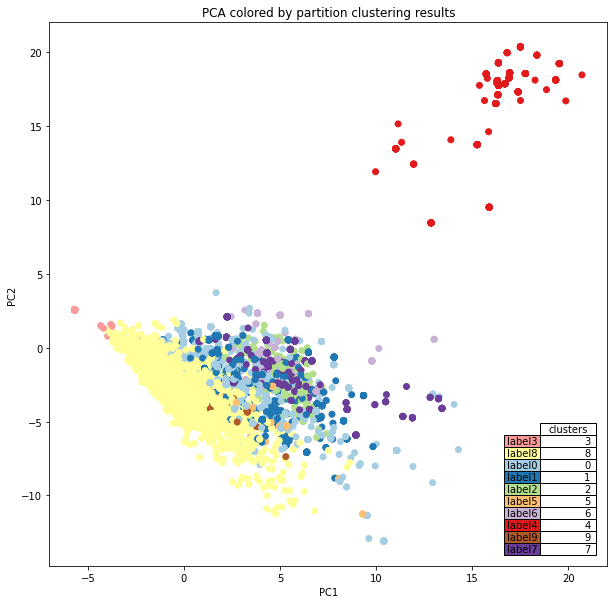

In [101]:
# Reference for legend/table in this plotting function:
# https://stackoverflow.com/questions/42056713/matplotlib-scatterplot-with-legend

# Note to grader: I know that the legend/table is not in numerically increasing
# order, but I spent a long time trying to get a legend/table that actually appears
# on the plot and accurately maps to the correct cluster. The row order here is a
# bit unusual, but it is functional and accurate.

# Plot PCA colored by partition clustering results
a = pca_and_cpa[:,2]
unique_classes=[int(a[i]) for i in sorted(np.unique(a, return_index=True)[1])]
cmap = plt.cm.get_cmap("Paired", 10)
plt.rcParams["figure.figsize"] = (10,10)
plt.scatter(pca_and_cpa[:,0], pca_and_cpa[:,1], c=pca_and_cpa[:,2], cmap=cmap)
plt.title("PCA colored by partition clustering results")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.table(cellText=[[x] for x in unique_classes], loc='lower right',
          colWidths=[0.1],
          rowColours=cmap(np.array(unique_classes)),
          rowLabels=['label%d'%x for x in unique_classes],
          colLabels=['clusters'])
plt.savefig("part2_plots/q3-pca.png")

In [27]:
# Load tsne values
tsne_vals = np.load("part2_results_data/q2-tsne_vals.npy")

# Get cluster assignments for subset
sub_idx = np.load("part2_results_data/sub_idx.npy")
cpa_sub_array = cpa_array[sub_idx]

# Make array with both
tsne_and_cpa = np.hstack((tsne_vals, cpa_sub_array[:,None]))

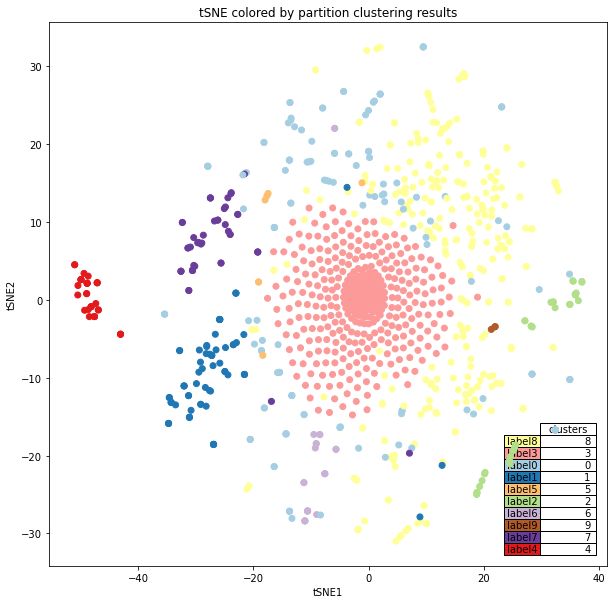

In [100]:
# Plot tSNE colored by partition clustering results
a = tsne_and_cpa[:,2]
unique_classes=[int(a[i]) for i in sorted(np.unique(a, return_index=True)[1])]
cmap = plt.cm.get_cmap("Paired", 10)
plt.rcParams["figure.figsize"] = (10,10)
plt.scatter(tsne_and_cpa[:,0], tsne_and_cpa[:,1], c=tsne_and_cpa[:,2], cmap=cmap)
plt.title("tSNE colored by partition clustering results")
plt.xlabel("tSNE1")
plt.ylabel("tSNE2")
plt.table(cellText=[[x] for x in unique_classes], loc='lower right',
          colWidths=[0.1],
          rowColours=cmap(np.array(unique_classes)),
          rowLabels=['label%d'%x for x in unique_classes],
          colLabels=['clusters'])
plt.savefig("part2_plots/q3-tsne.png")

In [97]:
# Note: the pca visualization includes all the data and the tsne visualization
# just includes the subset. Consequently, all 10 clusters are represented in
# the pca visualization but 9/10 are represented for tsne visualization

print("Num clusters represented in pca viz: ", str(len(set(pca_and_cpa[:,2]))))
print("Num clusters represented in tsne viz: ", str(len(set(tsne_and_cpa[:,2]))))

Num clusters represented in pca viz:  10
Num clusters represented in tsne viz:  9


### Question 4

answer

### Question 5

In [1]:
from clusters import algs
import numpy as np

# Load ligands
ligs = algs.load_ligands("ligand_information.csv")

# Get subset for hierarchical clustering
sub_idx = np.load("part2_results_data/sub_idx.npy")
lig_sub_coords = np.array([l.bit_string for l in ligs[sub_idx]])

# Evaluate number of clusters
k_scoresH = {}
for k in range(2,11):
    hck = algs.HierarchicalClustering(k)
    ck = hck.cluster(lig_sub_coords)
    s = algs.compute_silhouette_score(ck, lig_sub_coords)
    k_scoresH[k] = s
print(k_scoresH)

# Save results
np.save("part2_results_data/q5-kscores.npy", np.asarray(list(k_scoresH.items())))

{2: 0.15702337713310321, 3: 0.15022832886753007, 4: 0.1493658333002135, 5: 0.3875037068404428, 6: 0.37484976465891073, 7: 0.3662563828196964, 8: 0.3657252580668898, 9: 0.3636467203024084, 10: 0.3618902755929432}


In [10]:
# k=5 had the highest silhouette score so I will forge ahead with that

# Load ligands
ligs = algs.load_ligands("ligand_information.csv")

# Get subset for hierarchical clustering
sub_idx = np.load("part2_results_data/sub_idx.npy")
lig_sub_coords = np.array([l.bit_string for l in ligs[sub_idx]])

# Do hierarchical clustering
h = algs.HierarchicalClustering(5)
ch = h.cluster(lig_sub_coords)

# Save clusters
np.save("part2_results_data/q5-clusters.npy", ch)

In [3]:
# Confirm there are 5 clusters
len(ch)

5

In [31]:
# Load pca values
pca_vals = np.load("part2_results_data/q2-pca_vals.npy")

# Get cluster assignments
cha = algs.get_cluster_assignments(ch)
cha_array = np.asarray([cha[i] for i in range(len(cha))])

# Get subset of pca results
pca_sub_vals = pca_vals[sub_idx]

# Make array with both
pca_and_cha = np.hstack((pca_sub_vals, cha_array[:,None]))

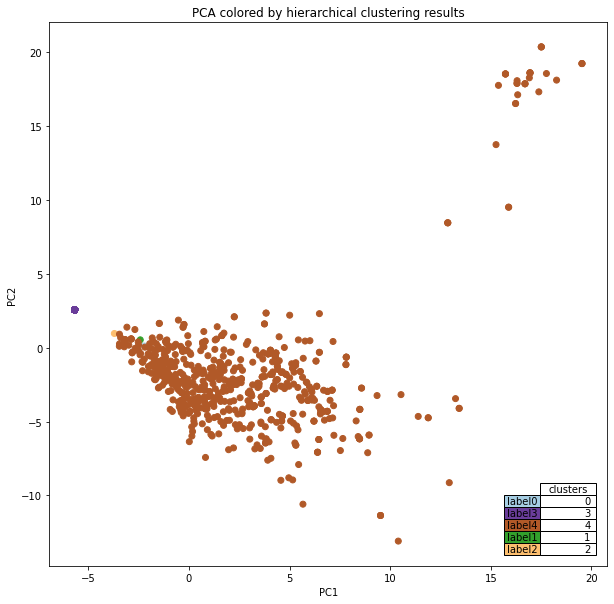

In [98]:
import matplotlib.pyplot as plt

# Plot PCA colored by hierarchical clustering results
a = pca_and_cha[:,2]
unique_classes=[int(a[i]) for i in sorted(np.unique(a, return_index=True)[1])]
cmap = plt.cm.get_cmap("Paired", 5)
plt.rcParams["figure.figsize"] = (10,10)
plt.scatter(pca_and_cha[:,0], pca_and_cha[:,1], c=pca_and_cha[:,2], cmap=cmap)
plt.title("PCA colored by hierarchical clustering results")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.table(cellText=[[x] for x in unique_classes], loc='lower right',
          colWidths=[0.1],
          rowColours=cmap(np.array(unique_classes)),
          rowLabels=['label%d'%x for x in unique_classes],
          colLabels=['clusters'])
plt.savefig("part2_plots/q5-pca.png")

In [7]:
# Load tsne values
tsne_vals = np.load("part2_results_data/q2-tsne_vals.npy")

# Make array with both
tsne_and_cha = np.hstack((tsne_vals, cha_array[:,None]))

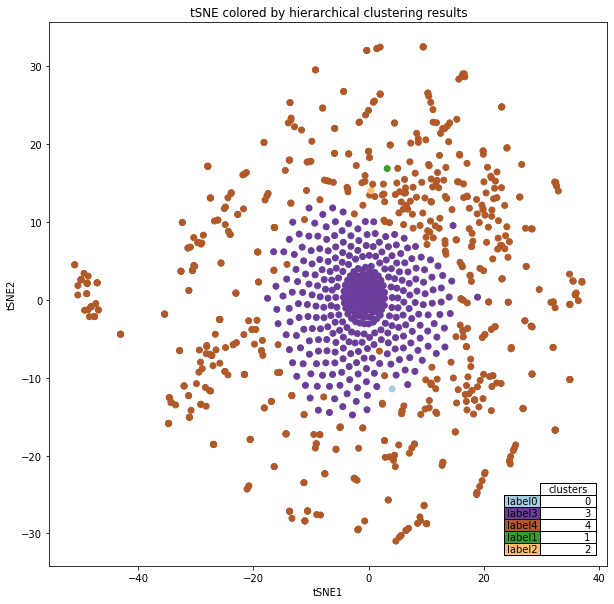

In [99]:
# Plot tSNE colored by hierarchical clustering results
a = tsne_and_cha[:,2]
unique_classes=[int(a[i]) for i in sorted(np.unique(a, return_index=True)[1])]
cmap = plt.cm.get_cmap("Paired", 5)
plt.rcParams["figure.figsize"] = (10,10)
plt.scatter(tsne_and_cha[:,0], tsne_and_cha[:,1], c=tsne_and_cha[:,2], cmap=cmap)
plt.title("tSNE colored by hierarchical clustering results")
plt.xlabel("tSNE1")
plt.ylabel("tSNE2")
plt.table(cellText=[[x] for x in unique_classes], loc='lower right',
          colWidths=[0.1],
          rowColours=cmap(np.array(unique_classes)),
          rowLabels=['label%d'%x for x in unique_classes],
          colLabels=['clusters'])
plt.savefig("part2_plots/q5-tsne.png")

### Question 6

answer

### Question 7

In [13]:
from clusters import algs

# Evaluate both clusterings using silhouette score

# Out of curiosity, compute silhouette score using both jaccard distance
# and euclidean distance

# Partition clustering
pc_sil_jac = algs.compute_silhouette_score(cp, lig_coords, dist_fun=algs.calc_jaccard_distance)
print(pc_sil_jac)
pc_sil_euc = algs.compute_silhouette_score(cp, lig_coords, dist_fun=algs.calc_euclidean_distance)
print(pc_sil_euc)

# Hierarchical clustering
hc_sil_jac = algs.compute_silhouette_score(ch, lig_sub_coords, dist_fun=algs.calc_jaccard_distance)
print(hc_sil_jac)
hc_sil_euc = algs.compute_silhouette_score(ch, lig_sub_coords, dist_fun=algs.calc_euclidean_distance)
print(hc_sil_euc)

0.38406790462373086
0.2839877287178786
0.3875037068404428
0.22071741644274478


### Question 8

In [21]:
# Create mapping between subset ids and subset indices
sub_map = {idx: id for id, idx in enumerate(sub_idx)}

# For clusters in partition clustering, get cluster members that are in subset
# and map ids to indices
cp_sub = np.array([algs.Cluster() for j in range(len(cp))])
for j in range(len(cp)):
    mems = []
    for m in cp[j].members:
        if m in sub_idx:
            mems.append(sub_map[m])
        cp_sub[j].members = np.array(mems)

In [22]:
# Compare clusterings
ji = algs.compute_jaccard_index(cp_sub, ch)
print(ji)

0.4374509015670929


In [23]:
# Out of curiosity, also do partition clustering on subset and compute jaccard index
cps = p.cluster(lig_sub_coords)
jis = algs.compute_jaccard_index(cps, ch)
print(jis)

0.5332851873823219


### Question 9

In [102]:
# Update ids to the original ids in the csv file
# (instead of the ligand indices)
ligs = algs.load_ligands("ligand_information.csv")
og_ids = np.array([l.id for l in ligs])
og_id_cp = algs.update_member_ids(og_ids, cp)

In [105]:
# Make map of id to score
id_score_map = {}
for l in ligs:
    id_score_map[l.id] = l.score

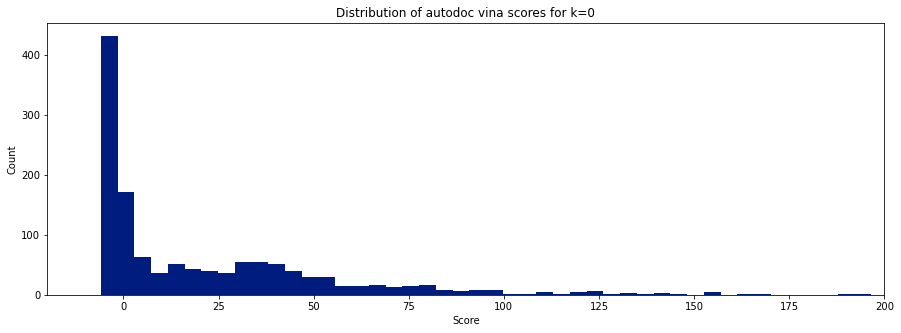

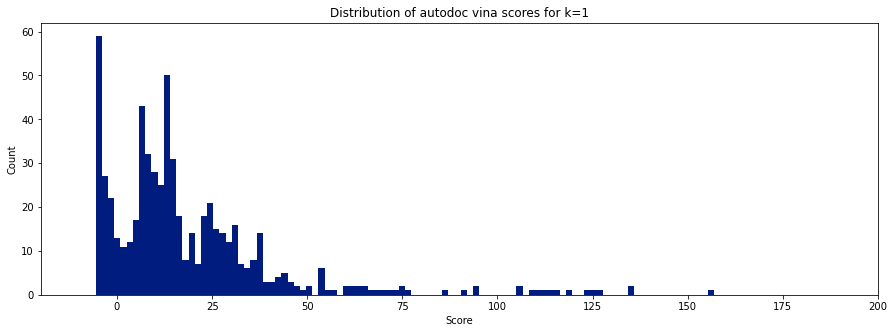

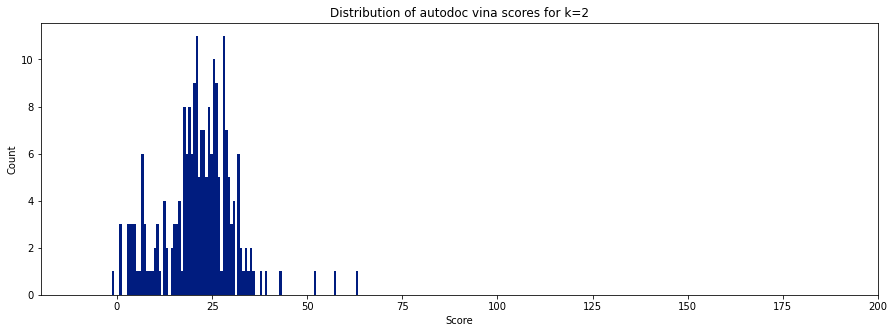

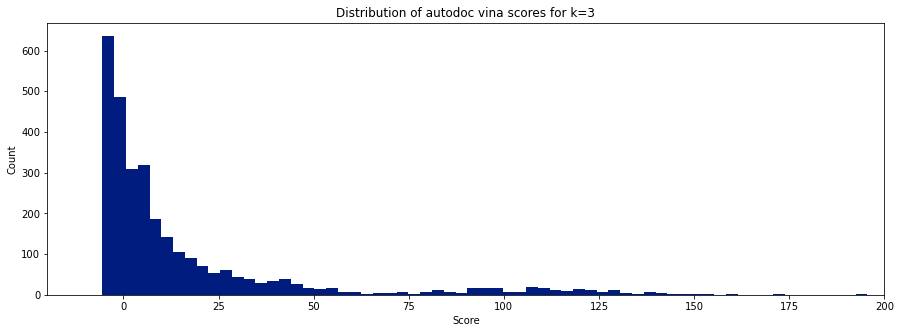

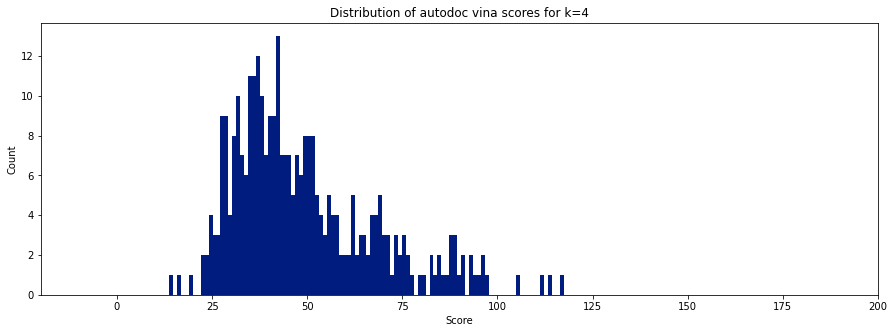

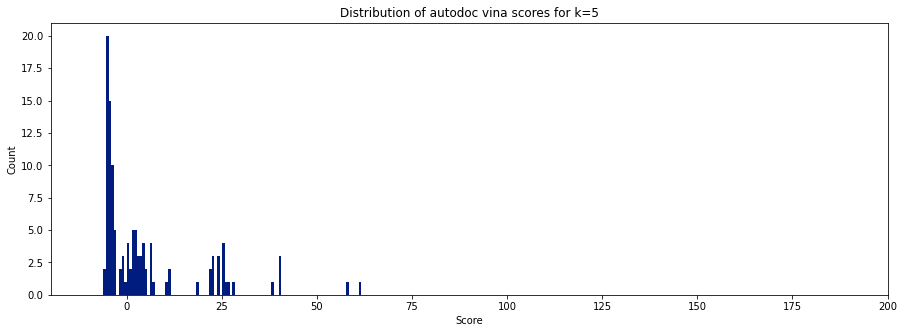

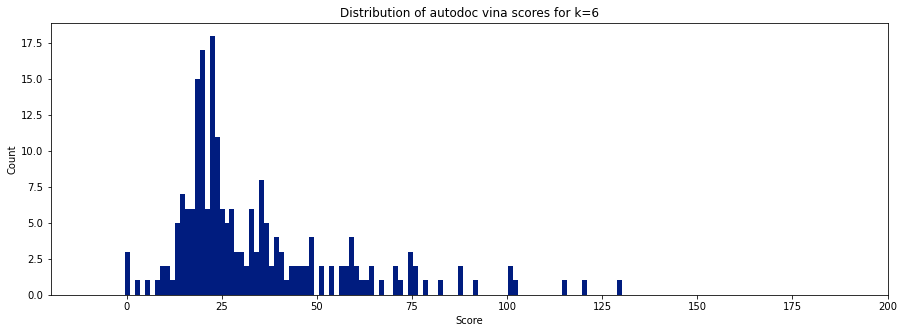

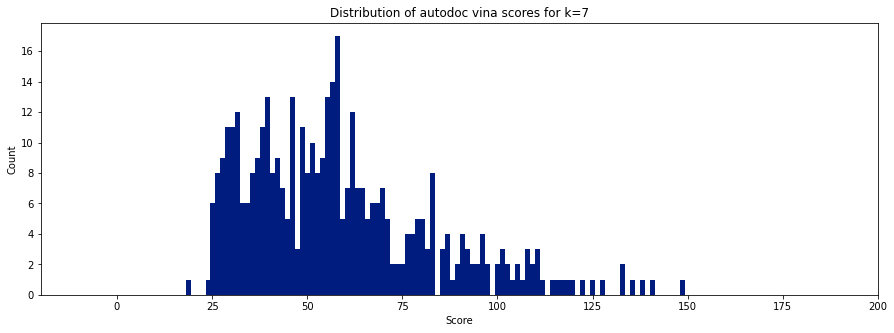

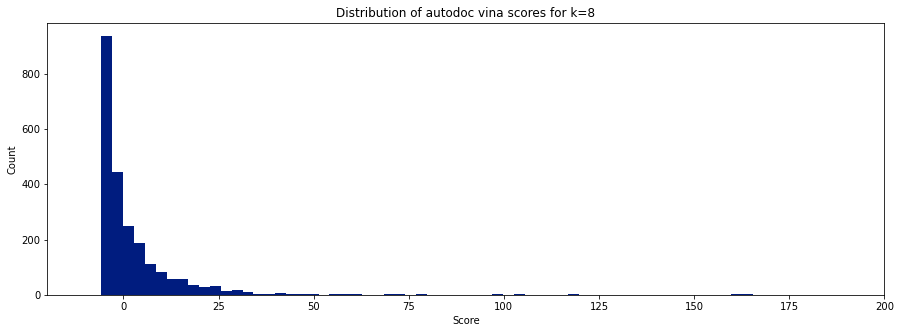

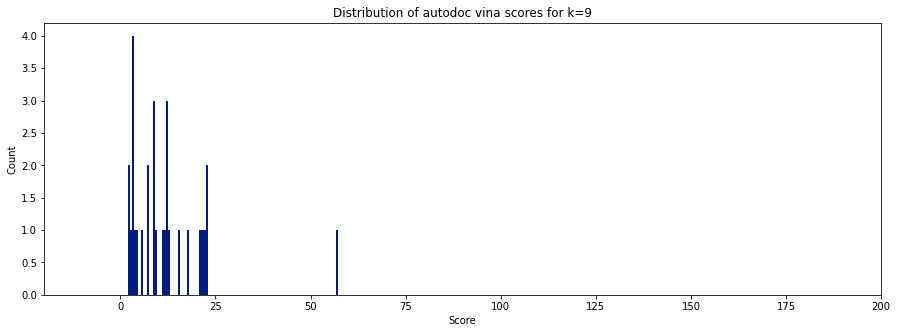

In [111]:
# Make q9 plotting function
def q9_plot(k):
    scores = []
    for m in og_id_cp[k].members:
        scores.append(id_score_map[m])
    plt.rcParams["figure.figsize"] = (15,5)
    plt.hist(scores, bins=100)
    plt.title("Distribution of autodoc vina scores for k=" + str(k))
    plt.xlabel("Score")
    plt.ylabel("Count")
    plt.xlim(-20, 200)
    plt.savefig("part2_plots/q9_" + str(k) + ".png")
    plt.show()
    
# Generate plots
for k in range(10):
    q9_plot(k)
    
# Note: a few plots have outliers with scores between 200-500. I set
# the xlims from -20 to 200 because that illustrated the main
# distributional similarities/differences between cluster scores

### Question 10

In [115]:
# Select top scoring molecule from each cluster
cluster_heads = {}
for j in range(len(og_id_cp)):
    chead = -1
    chead_score = np.inf
    for m in og_id_cp[j].members:
        if id_score_map[m] < chead_score:
            chead = m
            chead_score = id_score_map[m]
    cluster_heads[j] = (chead, chead_score)
print(cluster_heads)

{0: (740, -5.9), 1: (755, -5.6), 2: (2241, -1.4), 3: (1267, -5.5), 4: (4970, 13.7), 5: (2019, -6.1), 6: (2570, -0.4), 7: (5941, 18.0), 8: (883, -5.8), 9: (5174, 2.0)}


Top 5 (id, score, cluster):
1. 2019, -6.1, 5
2. 740, -5.9, 0
3. 883, -5.8, 8
4. 755, -5.6, 1
5. 1267, -5.5, 3

Screenshots from the top 5 pymol exploration are in part2_plots/question_10/.